# EDA + Data Cleansing

In [65]:
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
from impyute.imputation.cs import fast_knn
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from scipy import stats

# %matplotlib inline
warnings.filterwarnings('ignore')

# set sandbox_mode boolean for image building
* if sandbox_mode = True: faster to run, but images won't be generated

In [66]:
sandbox_mode = False

# define functions

In [67]:
def get_numerical_mask(df):
    type_mask = []
    for i in df.dtypes:
        if str(i).startswith('float') or str(i).startswith('int'): # or str(i).startswith('bool')
            type_mask.append(True)
        else: type_mask.append(False)
    num_cols = list(np.array(df.columns)[type_mask])
    other_cols = list(np.array(df.columns)[[not elem for elem in type_mask]])
    
    return num_cols, other_cols

### functions related to missing data

In [68]:
def get_missing(df):
    total = df.isnull().sum()
    percent = (df.isnull().sum()/df.isnull().count())
    missing_data = pd.concat([total, percent], axis=1, keys=['total', 'percent_missing'])
    missing_data['percent_missing'] = missing_data['percent_missing']
    missing_data['percent_missing'] = missing_data['percent_missing'].apply(lambda x: round(x,2))
    
    return missing_data

def drop_missing_from_threshold(df, row_threshold, col_threshold):
    row_count, col_count = df.shape
    # drop columns according to threshold of missing; use mask of columns which have less missing than threshold
    df = df.iloc[:, (df_missing['percent_missing'] < col_threshold).to_list()]
    
    # drop row according to threshold of missing
    n_cols = df.shape[1]
    df['ratio_mis'] = df.apply(lambda x: (n_cols - x.count())/n_cols, axis=1)
    df = df[df['ratio_mis']<row_threshold]
    df.drop(['ratio_mis'], axis=1, inplace=True)
    
    # count number of removals
    row_count_new, col_count_new = df.shape
    row_count_removal = row_count - row_count_new
    col_count_removal = col_count - col_count_new
    print('{} rows and {} columns were removed from database'.format(row_count_removal, col_count_removal))
    
    return df

def apply_imputation(df, method = 'knn', k=30, manual_val=-1):
    try:
        assert method in ['knn', 'mode', 'median', -1, 'manual']
    except AssertionError:
        raise ValueError('error: select a correct method for imputation: [knn, mode, median, -1, manual]')
        
    if method == 'knn':
        sys.setrecursionlimit(100000) #Increase the recursion limit of the OS
        numerical_cols, other_cols = get_numerical_mask(df)
        
#         df =  StandardScaler().fit_transform(df) # scale for knn to work properly (it's distance based)

        # start the KNN training
        imputed_training = fast_knn(df[numerical_cols], k=30)

        # retrieve column names
        imp_cols = imputed_training.columns.to_list()
        imputed_training.rename({imp_cols[i]: numerical_cols[i] for i in range(len(imp_cols))}, axis = 1, inplace=True)
        df.reset_index(inplace=True)
        other_cols.append('id')
        df = df[other_cols].merge(imputed_training, left_index=True, right_index=True)
        df.set_index('id', inplace=True)
        
    elif method == 'mode':
        df.fillna(data.mode().iloc[0], inplace=True)
        
    elif method == 'median':
        df.fillna(df.median(), inplace=True)

    elif method == -1:
        df.fillna(-1, inplace=True)
    
    elif method == 'manual':
        df.fillna(manual_val, inplace=True)
        
    try:
        assert df[df.isna().any(axis=1)].shape[0] == 0
    except AssertionError:
        raise ValueError('there are still missing values')
    
    return df

### functions related to outliers

In [69]:
def apply_standard_deviation_tol(df, tol=3):
    #scale data for operation
    df = pd.DataFrame(StandardScaler().fit_transform(df[numerical_cols]))
    
    z = np.abs(stats.zscore(df))
    z = pd.DataFrame(z, columns = df.columns, index=df.index)
    z.fillna(0, inplace=True)
    for col in z.columns[2:]:
        z = z[z[col]<tol]
    print("{0:.2%} of data was removed after dealing with outliers".format((df.shape[0]-z.shape[0])/df.shape[0]))
    df = df.loc[z.index, :]
    
    return df

def apply_isolation_forest(df, contamination=0.05):
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42) # contamination='auto' or 0.05
    clf.fit(df)

    outlier_pred = clf.predict(df)
    print('number of outliers:', np.count_nonzero(outlier_pred == -1), 'from a total of {}'.format(len(outlier_pred)))
    print('percentage of outliers: {0:.0%}'.format(np.count_nonzero(outlier_pred == -1)/np.count_nonzero(outlier_pred == 1)))
    
    return outlier_pred

def get_outliers(df, label, cols, method = 'isolation_forest', if_contamination = 0.05, z_tol = 3):

    if method == 'isolation_forest':
        outliers = apply_isolation_forest(df, if_contamination)
    elif method == 'standard_deviation_tol':
        df = apply_standard_deviation_tol(df, z_tol)
    
    print(len(outliers))
    return outliers, label

# Define paths and capture data

In [70]:
inputs = os.path.join('..', 'data', '02_intermediate')
outputs = os.path.join('..', 'data', '02_intermediate')
reports = os.path.join('..', 'data', '06_reporting')

In [71]:
data               = pd.read_csv(os.path.join(inputs, 'X_train.csv'), index_col='id')
data_test          = pd.read_csv(os.path.join(inputs, 'X_test.csv'), index_col='id')
y_train            = pd.read_csv(os.path.join(inputs, 'y_train.csv'), index_col='id')
y_test             = pd.read_csv(os.path.join(inputs, 'y_test.csv'), index_col='id')

In [72]:
print('Dataset dimensions:', data.shape)
data.head()

Dataset dimensions: (7000, 53)


,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,card6,addr1,...,d15,m1,m2,m3,m4,m5,m6,m7,m8,m9
id,,,,,,,,,,,,,,,,,,,,,
3486774,13107389,38.056,C,9633,130.0,185.0,visa,138.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3062695,1650884,150.000,R,15063,514.0,150.0,visa,226.0,credit,194.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3273443,7048761,56.500,W,9006,555.0,143.0,mastercard,224.0,debit,502.0,...,2.0,1.0,1.0,1.0,M0,0.0,NaN,0.0,0.0,1.0
3384445,10011292,8.459,C,11201,103.0,185.0,visa,226.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3489059,13159069,77.950,W,7919,194.0,150.0,mastercard,166.0,debit,315.0,...,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0


# Checking  for possible anomalies in the database

In [73]:
data.describe()

,transactiondt,transactionamt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,...,d14,d15,m1,m2,m3,m5,m6,m7,m8,m9
count,7.000000e+03,7000.000000,7000.000000,6887.000000,6988.000000,6953.000000,6186.000000,6186.000000,2885.000000,478.000000,...,733.000000,5965.000000,3846.000000,3846.000000,3846.000000,2829.000000,4975.000000,2912.000000,2912.000000,2912.000000
mean,7.371462e+06,135.783307,9846.589143,360.191230,153.454207,198.604919,289.808115,86.795829,119.299133,283.133891,...,52.549795,164.544510,0.999740,0.889236,0.776391,0.451396,0.462513,0.135302,0.355082,0.841003
std,4.602160e+06,243.345578,4929.417152,158.149983,11.433295,41.764167,102.079359,2.569743,363.741576,622.359626,...,129.863597,203.936009,0.016125,0.313881,0.416717,0.497720,0.498643,0.342105,0.478620,0.365736
min,8.841000e+04,0.272000,1001.000000,100.000000,100.000000,100.000000,110.000000,19.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.024309e+06,42.553250,6019.000000,206.000000,150.000000,166.000000,204.000000,87.000000,3.000000,7.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,7.329987e+06,67.950000,9596.000000,361.000000,150.000000,226.000000,299.000000,87.000000,8.000000,66.000000,...,0.000000,54.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.122393e+07,120.125000,14254.500000,512.000000,150.000000,226.000000,330.000000,87.000000,25.000000,296.000000,...,0.000000,315.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,1.581012e+07,4463.950000,18387.000000,600.000000,219.000000,237.000000,536.000000,96.000000,4966.000000,7104.000000,...,730.000000,807.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# missing data
usually, missing data is solved by filling it with some metric such as median. If the number of missing data in some entry is too high, we must evaluate for the removal of those entries.
For categorical with missing data, if you want to encode missing values, first change its type to a string:
```python
a[pd.isnull(a)]  = 'NaN'
```
Some refs:
* https://stackoverflow.com/questions/36808434/label-encoder-encoding-missing-values

About the missing values, we can't assume beforehand if those are Missing at Random (MAR) or Missing not at Random (MNAR). Further investigation would be necessary to properly decide over how to handle it.

For now, I am assuming they are Missing at Random. So I will remove some of them through a threshold, and apply imputation for the rest. By applying a proper imputation I observed a slight improvement over the score.

The catch is that applying imputation over euclidean distances can be extremely imprecise.

### drop columns and rows for threshold of missing

In [74]:
print('SORTED LIST OF MISSING VALUES')
df_missing = get_missing(data)
df_missing_vis = df_missing[df_missing['total'] > 0]
df_missing_vis['percent_missing'] = df_missing_vis['percent_missing'].apply(lambda x: round(x, 2))
# df_missing_vis.sort_values(by='percent_missing', ascending=False).head(20)
df_missing_vis.sort_values(by='percent_missing', ascending=False)

SORTED LIST OF MISSING VALUES


,total,percent_missing
d7,6539,0.93
dist2,6522,0.93
d14,6267,0.90
d13,6263,0.89
d12,6203,0.89
d6,6118,0.87
d9,6094,0.87
d8,6094,0.87
r_emaildomain,5353,0.76
m5,4171,0.60


In [75]:
col_mis_threshold = 0.8
row_mis_threshold = 0.5

In [76]:
data = drop_missing_from_threshold(data, row_mis_threshold, col_mis_threshold)

0 rows and 8 columns were removed from database


### visualize rows with missing
we already know that the critical columns are related to geo_location

In [77]:
sandbox_mode = True
if sandbox_mode:
    print('number of missing:', data[data.isna().any(axis=1)].shape[0])
data[data.isna().any(axis=1)].tail()

number of missing: 7000


,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,card6,addr1,...,d15,m1,m2,m3,m4,m5,m6,m7,m8,m9
id,,,,,,,,,,,,,,,,,,,,,
3522222,14086521,1331.000,W,18268,583.0,150.0,visa,226.0,credit,181.0,...,236.0,1.0,1.0,0.0,M0,0.0,0.0,0.0,1.0,1.0
2995416,252748,30.000,W,3507,NaN,150.0,visa,226.0,credit,204.0,...,29.0,NaN,NaN,NaN,M0,1.0,1.0,NaN,NaN,NaN
3336090,8616048,16.767,C,18250,545.0,185.0,visa,226.0,credit,284.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3533234,14417117,82.950,W,10972,111.0,150.0,mastercard,224.0,debit,181.0,...,628.0,1.0,1.0,1.0,NaN,NaN,1.0,0.0,0.0,1.0
3245820,6207878,107.950,W,14290,512.0,150.0,visa,226.0,debit,225.0,...,101.0,1.0,1.0,1.0,NaN,NaN,0.0,0.0,0.0,1.0


### get types of columns

In [78]:
numerical_cols, other_cols = get_numerical_mask(data)
other_cols = []

### imputation of missing values
For continuous values, I would prefer knn over median, but it depends on normalized dataset. Nevertheless, we don't have missing on continuous datasets, even though we could encode categorical data. But the encoding step wasn't organized to precede this notebook, so I will stick to 'mode', which imputes the most frequent value.

Some refs:
* https://jamesrledoux.com/code/imputation#:~:text=One%20approach%20to%20imputing%20categorical,given%20in%20Pandas'%20value_counts%20function.

the apply_imputation function accepts the following methods: knn, median, mode, or -1 (impute as category -1 [for categorical vars])

In [79]:
data.head()

,transactiondt,transactionamt,productcd,card1,card2,card3,card4,card5,card6,addr1,...,d15,m1,m2,m3,m4,m5,m6,m7,m8,m9
id,,,,,,,,,,,,,,,,,,,,,
3486774,13107389,38.056,C,9633,130.0,185.0,visa,138.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3062695,1650884,150.000,R,15063,514.0,150.0,visa,226.0,credit,194.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3273443,7048761,56.500,W,9006,555.0,143.0,mastercard,224.0,debit,502.0,...,2.0,1.0,1.0,1.0,M0,0.0,NaN,0.0,0.0,1.0
3384445,10011292,8.459,C,11201,103.0,185.0,visa,226.0,debit,NaN,...,0.0,NaN,NaN,NaN,M2,NaN,NaN,NaN,NaN,NaN
3489059,13159069,77.950,W,7919,194.0,150.0,mastercard,166.0,debit,315.0,...,0.0,1.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,0.0


In [80]:
# imputation over numerical variables
data[numerical_cols] = data[numerical_cols].astype(float)
if data[numerical_cols].isnull().values.any():
    data[numerical_cols] = apply_imputation(data[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data[other_cols].isnull().values.any():
    data[other_cols] = apply_imputation(data[other_cols], method = 'mode', k = 30)
    
# manual imputation on lag and forecast variables
# manual_cols = ['lag_1', 'lag_2', 'lag_3']
# if data[manual_cols].isnull().values.any():
#     data[manual_cols] = apply_imputation(data[manual_cols], method = 'manual', manual_val = False)
# data_test['y'].fillna(value=data_test['y'], inplace=True)

In [85]:
# imputation over numerical variables
data_test[numerical_cols] = data_test[numerical_cols].astype(float)
if data_test[numerical_cols].isnull().values.any():
    data_test[numerical_cols] = apply_imputation(data_test[numerical_cols], method = 'knn', k = 30)

# imputation over categorical variables
if data_test[other_cols].isnull().values.any():
    data_test[other_cols] = apply_imputation(data_test[other_cols], method = 'mode', k = 30)

# anomaly detection
remove outliers from choosing one of the following methods: isolation_forest, standard_deviation_tol (using z_score on standardized version)

other parameters are:
* if_contamination: isolation forest level of contamination
* z_tol: tolerance for standard deviation (if using zscore)

It is not advisable to remove outliers without proper consideration.

Some interesting refs:
* https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
* https://towardsdatascience.com/anomaly-detection-with-isolation-forest-visualization-23cd75c281e2
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e

In [86]:
# temporarily add train to test data (no leakage here)
test_start = data_test.index[0]
data_test = data.append(data_test)

# get outliers on train data
data['if_anomaly'], _ = get_outliers(data[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# get outliers on test data (needs trainset)

data_test['if_anomaly'], _ = get_outliers(data_test[numerical_cols], y_train, numerical_cols, 
                                                  method = 'isolation_forest', if_contamination = 0.05)

# removes trainset again
data_test = data_test[data_test.index >= test_start]

number of outliers: 350 from a total of 7000
percentage of outliers: 5%
7000
number of outliers: 1549 from a total of 31000
percentage of outliers: 5%
31000


outlier removal isn't justified for this for now

In [89]:
remove_outliers = False

In [90]:
if remove_outliers:
    data = data[data['if_anomaly'] == 1]
    y_train = y_train[y_train.index.isin(data.index.to_list())]

# drop redundant features

# Visualize pairwise relations
When datasets have just a few variables (10–15), pairplots allow for a quick visual inspection of those relations, as well as bariable distributions.

In [91]:
numerical_cols, other_cols = get_numerical_mask(data)

In [92]:
separator = int(len(numerical_cols)/2)

#### group 1

In [93]:
if not sandbox_mode:
    data_vis = data[numerical_cols[:separator]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_1.jpg'), bbox_inches = "tight")

#### group 2

In [94]:
if not sandbox_mode:
    data_vis = data[numerical_cols[separator:]]
    data_vis['y'] = y_train['y']
    print('visualize pairplots')
    sns.pairplot(data_vis, plot_kws={'alpha': 0.1});
    plt.savefig(os.path.join(reports,'01_pairplots_2.jpg'), bbox_inches = "tight")

# Check if data is imbalanced
When data is imbalanced, we must evaluate for solutions such as oversampling or undersamplig, which might be done with techniques such as SMOTE (Synthetic Minority Oversampling Technique).

In [95]:
y = y_train.append(y_test)

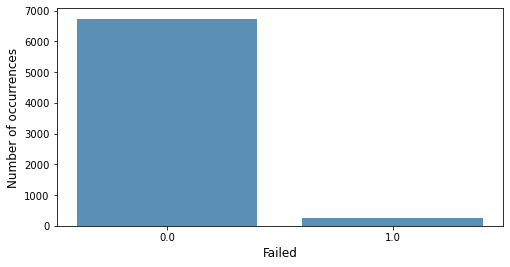

In [96]:
color = sns.color_palette()
classif = y_train['y'].value_counts()
plt.figure(figsize=(8,4))
sns.barplot(classif.index, classif.values, alpha=0.8, color=color[0])
plt.ylabel('Number of occurrences', fontsize=12)
plt.xlabel('Failed', fontsize=12)
plt.plot()
plt.savefig(os.path.join(reports,'imbalance.jpg'), bbox_inches = "tight")

In [97]:
counts = y['y'].value_counts()
counts

0.0    9637
1.0     363
Name: y, dtype: int64

In [98]:
print('ratio between classes:',round(counts[0]/counts[1],2))
print('\r\nCheck proportions below:')
y['y'].value_counts(normalize=True)

ratio between classes: 26.55

Check proportions below:


0.0    0.9637
1.0    0.0363
Name: y, dtype: float64

# Description (2nd round)

In [99]:
if sandbox_mode:
    print(data.shape[0])
    print(y_train.shape[0])
    data.describe()

7000
7000


# save intermediate data

In [100]:
data.to_csv(os.path.join(outputs, 'X_train.csv'))
data_test.to_csv(os.path.join(outputs, 'X_test.csv'))

y_train.to_csv(os.path.join(outputs, 'y_train.csv'))
y_test.to_csv(os.path.join(outputs, 'y_test.csv'))